In [100]:
# Standard Libraries
import os 
import pandas as pd
import datetime
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

# Specific Libraries
import sklearn.linear_model as linear_model
import sklearn.preprocessing as preprocessing 
from sklearn import tree, metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

plt.rcParams['figure.figsize'] = (18, 8)

In [62]:
data = pd.read_csv("takehome_users.csv", engine='python')

A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:
● name: the user's name
● object_id: the user's id
● email: email address
● creation_source: how their account was created. This takes on one
of 5 values:
○ PERSONAL_PROJECTS: invited to join another user's
personal workspace
○ GUEST_INVITE: invited to an organization as a guest
(limited permissions)
○ ORG_INVITE: invited to an organization (as a full member)
○ SIGNUP: signed up via the website
○ SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login
id)
● creation_time: when they created their account
● last_session_creation_time: unix timestamp of last login
● opted_in_to_mailing_list: whether they have opted into receiving
marketing emails
● enabled_for_marketing_drip: whether they are on the regular
marketing email drip
● org_id: the organization (group of users) they belong to
● invited_by_user_id: which user invited them to join (if applicable).

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period, identify which factors predict future user adoption.

In [63]:
data.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [64]:
data.shape

(12000, 10)

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [66]:
data['last_session_creation_time'].fillna(data['last_session_creation_time'].median(), inplace=True)
data['invited_by_user_id'].fillna(data['invited_by_user_id'].median(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [67]:
user_df= pd.read_csv('takehome_user_engagement.csv')

In [68]:
user_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [69]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [70]:
A=len(user_df.groupby('user_id') ['visited'].nunique())
A

8823

In [71]:
B=len(data.groupby('object_id')['name'].nunique())
B

12000

In [72]:
#Calculating the number of non-users of the application
print(B - A)

3177


In [73]:
#Extracting hours from time_stamp and building new column login_date
user_df['login_date']=user_df['time_stamp'].apply(lambda x:x[:10])
user_df.head(3)

,time_stamp,user_id,visited,login_date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29


In [74]:
#Building a function to identify adopted users who are logged into the product on three separate days and assign as adopted=1, else adopted=0
def adapt_user(logins):
    adp=False #flag to check if the user is engaged
    adp_rt=0
    if len(logins)<3:
        return adp_rt
    i=0
    while (~adp) & (i+2<len(logins)):
        first_login_dt=pd.to_datetime(logins.values[i])
        second_login_dt=pd.to_datetime(logins.values[i+1])

       
        while (((first_login_dt-second_login_dt).days) >= 1) & (i+2<len(logins)):
            i=i+1
            second_login_dt=pd.to_datetime(logins.values[i+1])
        third_login_dt=pd.to_datetime(logins.values[i+2])
        
        #find if third login date is not the same day as the second day
        while (((second_login_dt-third_login_dt).days) >= 1) & (i+2<len(logins)):
            i=i+1
            third_login_dt=pd.to_datetime(logins.values[i+1])
        
        #check if the diff between three successive login is less than 7 days
        if ((third_login_dt-first_login_dt).days) < 7:
            adp=True
            adp_rt=1
        i=i+1

    return adp_rt

In [75]:
# Building a data set consisting user_id and login_df only
user_egm=user_df[['user_id','login_date']].groupby('user_id')

In [76]:
#Building a dictionary to create user and adapted columns
usr_eng_dict={}
for i in user_egm:
    user=i[1]['user_id'].iloc[0]
    login_times=i[1]['login_date']
    usr_eng_dict[user]=adapt_user(login_times)

In [77]:
usr_eng_df=pd.DataFrame(pd.Series(usr_eng_dict)).reset_index()

In [78]:
usr_eng_df.columns=['user','adopted']

In [79]:
usr_eng_df.head()

,user,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


In [80]:
data=data.set_index('object_id')

In [81]:
usr_eng_df= usr_eng_df.set_index('user')

In [82]:
usr_eng_df.head()

,adopted
user,
1,0
2,1
3,0
4,0
5,0


In [83]:
data.head(3)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


In [84]:
data=pd.concat([data,usr_eng_df],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   name                        12000 non-null  object 
 2   email                       12000 non-null  object 
 3   creation_source             12000 non-null  object 
 4   last_session_creation_time  12000 non-null  float64
 5   opted_in_to_mailing_list    12000 non-null  int64  
 6   enabled_for_marketing_drip  12000 non-null  int64  
 7   org_id                      12000 non-null  int64  
 8   invited_by_user_id          12000 non-null  float64
 9   adopted                     8823 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 1.0+ MB


In [85]:
data['adopted']=data['adopted'].fillna(0)

In [86]:
data['adopted'].mean()*100

13.350000000000001

In [87]:
#percentage of engaged users by email opt in
data[['opted_in_to_mailing_list','adopted']].groupby('opted_in_to_mailing_list')['adopted'].mean()

opted_in_to_mailing_list
0    0.131912
1    0.138277
Name: adopted, dtype: float64

In [88]:
data[['enabled_for_marketing_drip','adopted']].groupby('enabled_for_marketing_drip')['adopted'].mean()

enabled_for_marketing_drip
0    0.132837
1    0.137277
Name: adopted, dtype: float64

In [89]:
data[['creation_source','adopted']].groupby('creation_source')['adopted'].mean()

creation_source
GUEST_INVITE          0.166436
ORG_INVITE            0.129995
PERSONAL_PROJECTS     0.077688
SIGNUP                0.140393
SIGNUP_GOOGLE_AUTH    0.167509
Name: adopted, dtype: float64

In [90]:
data.head(3)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0


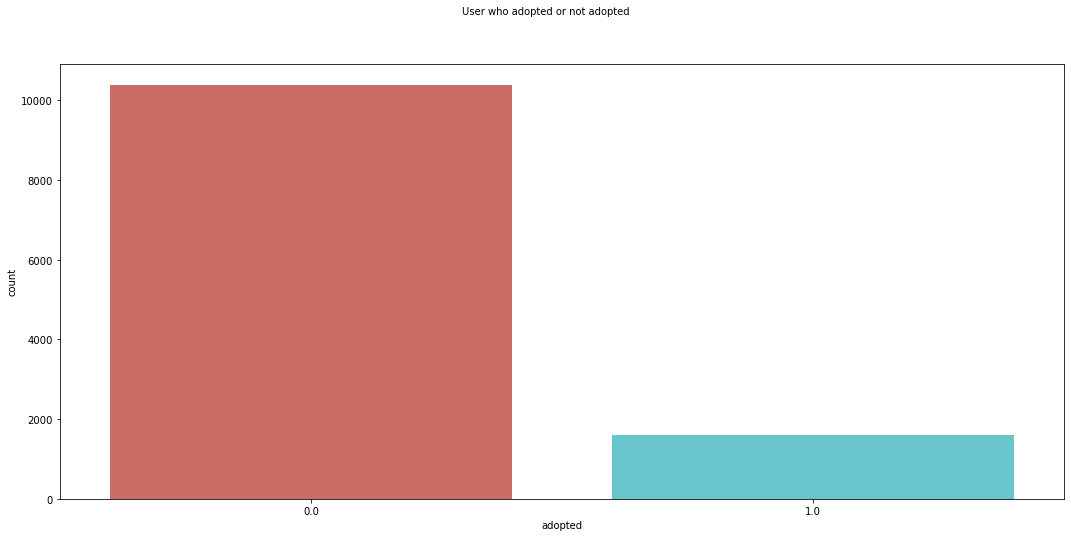

In [91]:
plt.suptitle("User who adopted or not adopted", fontsize=10)
sns.countplot(x='adopted', data=data, palette='hls')
plt.show()

In [92]:
print("Total records: ", len(data))
print("Records for adopted user,'Yes',: ", sum(data.adopted == 1))
print("Records for non-adopted user,'No',: ", sum(data.adopted == 0))

Total records:  12000
Records for adopted user,'Yes',:  1602
Records for non-adopted user,'No',:  10398


In [93]:
#import the resampling module from Scikit-Learn library
from sklearn.utils import resample 
# Distinguish majority and minority classes
df_majority = data[data.adopted==0]
df_minority = data[data.adopted==1]
 
# Upsampling minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=10398,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combining majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Displaying new class counts
df_upsampled.adopted.value_counts()

1.0    10398
0.0    10398
Name: adopted, dtype: int64

In [94]:
data_encod = pd.get_dummies(df_upsampled, columns = ['creation_source'])

data_encod.head()

,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,0.0,1,0,0,0,0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,0.0,0,1,0,0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,0.0,1,0,0,0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,0.0,1,0,0,0,0
6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,1.387424e+09,0,0,197,11241.0,0.0,1,0,0,0,0


In [95]:
cols = ["creation_time", "name", "email", "org_id",'invited_by_user_id']
for i in cols:
    del data_encod[i]

# Random Forest

In [96]:
y = data_encod.adopted
X = data_encod.drop('adopted', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [97]:
predicted = model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(accuracy)

0.959222927486055


In [98]:
ypred = model.predict(X_test)

In [99]:
from sklearn import metrics
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2389
         1.0       1.00      0.93      0.96      2810

    accuracy                           0.96      5199
   macro avg       0.96      0.96      0.96      5199
weighted avg       0.96      0.96      0.96      5199



# Feature Importance 

Features sorted by their score:
Feature ranking:
1. feature 0 (0.973186)
2. feature 5 (0.011057)
3. feature 2 (0.003713)
4. feature 1 (0.003584)
5. feature 3 (0.002858)
6. feature 7 (0.002274)
7. feature 4 (0.001756)
8. feature 6 (0.001573)
1. feature 0 (0.973186)
2. feature 5 (0.011057)
3. feature 2 (0.003713)
4. feature 1 (0.003584)
5. feature 3 (0.002858)
6. feature 7 (0.002274)
7. feature 4 (0.001756)
8. feature 6 (0.001573)


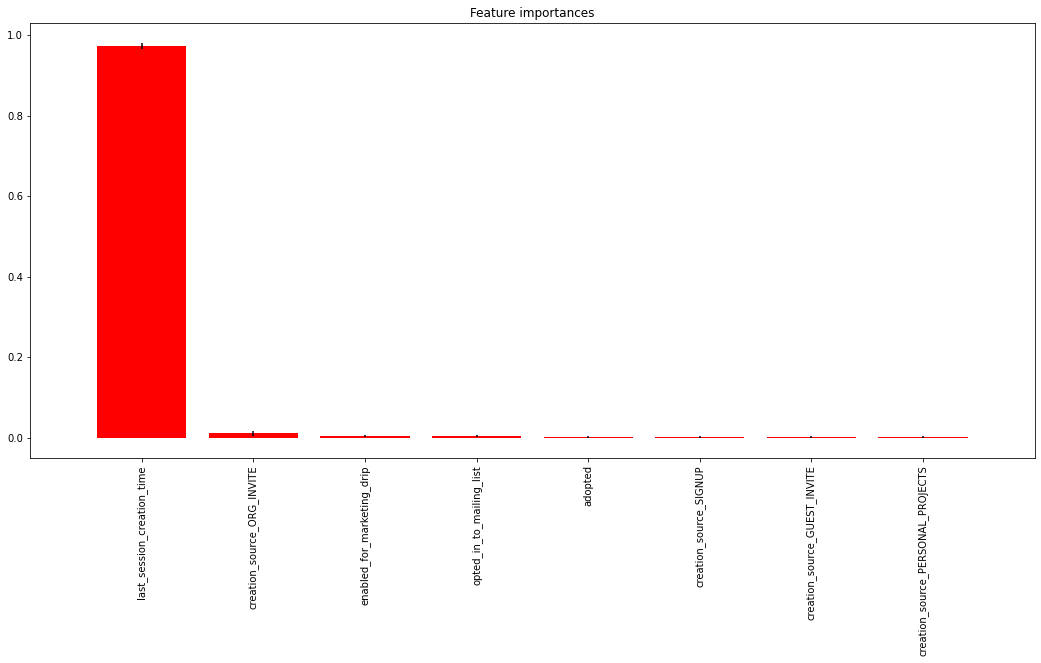

In [121]:
# Exploring the importance of the features
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
names = data_encod.columns.values

rf = RandomForestRegressor()
rf.fit(X, y)
print("Features sorted by their score:")
# print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=200,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
for f in range(X.shape[1]):
    indices = np.argsort(importances)[::-1]
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="red", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), names[indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

last_session_creation_time, creation_source_ORG_INVITE are important features to predicted if a user is adopted or not.